In [1]:
import numpy as np
import pandas as pd
import re
import math

import os.path
from os import path

from data_util import create_dataset, gene_selection, remove_mean_cutoffs_tumor
from data_util import get_healthy_genes, differential_gene_expression_analysis, setup_gene_name_dict
from data_util import run_enrichr, remove_mean_cutoffs_healthy, get_healthy2_gene_list, get_healthy_tissue_gene_exp_df

from clustering import elbow_method, run_km, get_cluster_dict, get_cluster_pathways

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind
from scipy.stats import norm

import gseapy as gp
import pickle as pkl
from matplotlib import pyplot as plt

# Read in data

###  Note that the loaded data has already been log_2(x+1) transformed from the raw values

In [2]:
cancer_type = 'BLCA'
cancer_origin = 'Bladder'
tumor_site1 = 'Lung'
tumor_site2 = 'Liver'
healthy_files_created = True

# List of cutoffs used in the analysis:
# 0) mean_cutoff_tumor_site1 = 1
# 1) mean_cutoff_tumor_site2 = 1
# 2) p_value_cutoff_tumor_site1 = 0.01
# 3) p_value_cutoff_tumor_site2 = 0.01
# 4) mean_cutoff_healthy2 = 4
# 5) p_value_cutoff_healthy2 = 0.01
cutoff_list = [1, 1, 0.01, 0.01, 1, 0.01]

In [3]:
filepath_new = '../mmc1-tony.xlsx'
data_new = pd.read_excel(filepath_new,index_col=0)

data_tumor_site1 = create_dataset(cancer_type = 'BLCA',
                                new_tumor_event_site = 'Lung',
                                data_new = data_new,
                                filepath_ge = '../BLCA/TCGA-BLCA.htseq_fpkm.tsv',
                                filepath_ph = '../BLCA/TCGA-BLCA.GDC_phenotype.tsv')

data_tumor_site2 = create_dataset(cancer_type = 'BLCA',
                                new_tumor_event_site = 'Liver',
                                data_new = data_new,
                                filepath_ge = '../BLCA/TCGA-BLCA.htseq_fpkm.tsv',
                                filepath_ph = '../BLCA/TCGA-BLCA.GDC_phenotype.tsv')

print('==========Raw Data==========')
print('{}-{} sample count: {}'.format(cancer_type, tumor_site1, data_tumor_site1.shape[0]))
print('{}-{} gene count: {}'.format(cancer_type, tumor_site1, data_tumor_site1.shape[1]))

print('\n{}-{} sample count: {}'.format(cancer_type, tumor_site2, data_tumor_site2.shape[0]))
print('{}-{} gene count: {}'.format(cancer_type, tumor_site2, data_tumor_site2.shape[1]))

==========Raw Data==========
BLCA-Lung sample count: 31
BLCA-Lung gene count: 60487

BLCA-Liver sample count: 12
BLCA-Liver gene count: 60487


In [4]:
# The pipeline requires two healthy gene expression datasets for each analysis

if healthy_files_created == False:

    sampleAttributesDS_path = '../GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt'
    gtexTCGA_path = '../TcgaTargetGtex_rsem_gene_fpkm'

    # Healthy tissue data to compare with the tumor data from the cancer origin site (e.g. BRCA_lung to healthy breast)
    healthy1_gene_exp_df = get_healthy_tissue_gene_exp_df(sample_attr_DS_path=sampleAttributesDS_path,
                                                      gtex_tcga_path=gtexTCGA_path,
                                                      tissue_str=cancer_origin)

    # Healthy tissue data to compare with the first metastatic site (e.g. BRCA_lung to healthy lung)
    healthy2_gene_exp_df = get_healthy_tissue_gene_exp_df(sample_attr_DS_path=sampleAttributesDS_path,
                                                      gtex_tcga_path=gtexTCGA_path,
                                                      tissue_str=tumor_site1)

    # Write healthy tissue data to csv
    healthy1_gene_exp_df.to_csv('../{}_gene_exp_healthy.csv'.format(cancer_origin))
    healthy2_gene_exp_df.to_csv('../{}_gene_exp_healthy.csv'.format(tumor_site1))

# Selection of Genes Related to Transporters and Enzymes

In [5]:
# Get names df - List of genes related to transporter and enzyme production
names_df = pd.read_csv('../ensembl_index.csv',index_col = 0)

# Get bladder-lung data
data_tumor_site1 = gene_selection(data_tumor_site1, names_df)

# Manually inspect to make sure all samples end in "01A" or "01B"
data_tumor_site1.drop('TCGA-GD-A2C5-11A', inplace=True) # Remove as sample ends in "11A"

# Get bladder-liver data
data_tumor_site2 = gene_selection(data_tumor_site2, names_df)

print('==========Post Gene Selection==========')
print('{}-{} sample count: {}'.format(cancer_type, tumor_site1, data_tumor_site1.shape[0]))
print('{}-{} gene count: {}'.format(cancer_type, tumor_site1, data_tumor_site1.shape[1]))

print('\n{}-{} sample count: {}'.format(cancer_type, tumor_site2, data_tumor_site2.shape[0]))
print('{}-{} gene count: {}'.format(cancer_type, tumor_site2, data_tumor_site2.shape[1]))    

==========Post Gene Selection==========
BLCA-Lung sample count: 30
BLCA-Lung gene count: 4192

BLCA-Liver sample count: 12
BLCA-Liver gene count: 4192


# Histograms and Mean Cutoffs of Tumor Samples

In [6]:
data_tumor_site1 = remove_mean_cutoffs_tumor(data_tumor_site1, cutoff = cutoff_list[0], plotting = False)
data_tumor_site2 = remove_mean_cutoffs_tumor(data_tumor_site2, cutoff = cutoff_list[1], plotting = False)

print('==========Post Mean Cutoffs==========')
print('{}-{} sample count: {}'.format(cancer_type, tumor_site1, data_tumor_site1.shape[0]))
print('{}-{} gene count: {}'.format(cancer_type, tumor_site1, data_tumor_site1.shape[1]))

print('\n{}-{} sample count: {}'.format(cancer_type, tumor_site2, data_tumor_site2.shape[0]))
print('{}-{} gene count: {}'.format(cancer_type, tumor_site2, data_tumor_site2.shape[1]))    

==========Post Mean Cutoffs==========
BLCA-Lung sample count: 30
BLCA-Lung gene count: 2959

BLCA-Liver sample count: 12
BLCA-Liver gene count: 2966


# Differential Gene Expression Analysis

In [7]:
filepath = '../Bladder_gene_exp_healthy.csv'
healthy1_trunc_df = get_healthy_genes(filepath)

tumor_site1_gene_list, _ = differential_gene_expression_analysis(data_tumor_site1, healthy1_trunc_df)
tumor_site2_gene_list, _ = differential_gene_expression_analysis(data_tumor_site2, healthy1_trunc_df)

print('==========Post Differential Gene Expression Analysis==========')
print('{}-{} gene count: {}'.format(cancer_type, tumor_site1, len(tumor_site1_gene_list)))
print('{}-{} gene count: {}'.format(cancer_type, tumor_site2, len(tumor_site2_gene_list)))

==========Post Differential Gene Expression Analysis==========
BLCA-Lung gene count: 234
BLCA-Liver gene count: 209


# K-Means Clustering

In [8]:
# Setup gene2idx dictionaries for tumor site 1 and tumor site 2
site1_gene2idx = {}
site1_idx2gene = {}

site2_gene2idx = {}
site2_idx2gene = {}    

for i, gene in enumerate(tumor_site1_gene_list):
    site1_gene2idx[gene] = i
    site1_idx2gene[i] = gene
    
for i, gene in enumerate(tumor_site2_gene_list):
    site2_gene2idx[gene] = i
    site2_idx2gene[i] = gene    

In [9]:
# Keep subset of genes that are effectively upregulated
tumor_site1_gene_list = np.array(tumor_site1_gene_list)
site1_gene_array = data_tumor_site1[tumor_site1_gene_list].to_numpy()
site1_gene_array_norm = preprocessing.normalize(site1_gene_array.T)

tumor_site2_gene_list = np.array(tumor_site2_gene_list)
site2_gene_array = data_tumor_site2[tumor_site2_gene_list].to_numpy()
site2_gene_array_norm = preprocessing.normalize(site2_gene_array.T)

===============Tumor Site 1===============


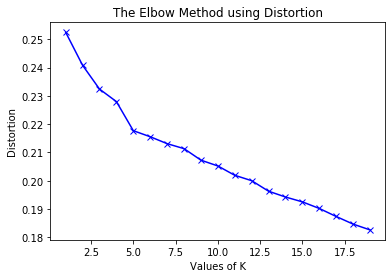

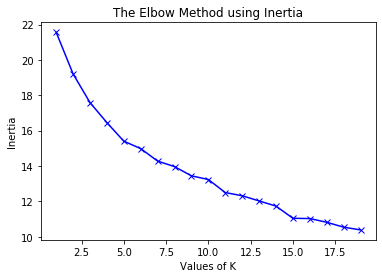


===============Tumor Site 2===============


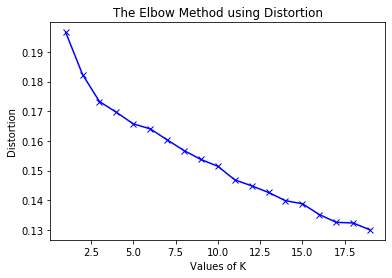

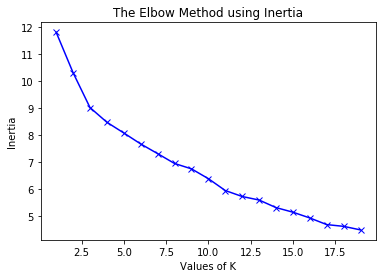

In [10]:
print('===============Tumor Site 1===============')
elbow_method(site1_gene_array_norm, verbose = False, plotting = True)

print('\n===============Tumor Site 2===============')
elbow_method(site2_gene_array_norm, verbose = False, plotting = True)

In [11]:
# Site1 K-Means

# Only run if pkl file of clusters doesn't exist
site1_clusters_filepath = "../site1_clusters.p"
site1_cluster_count = 4

if path.exists(site1_clusters_filepath) == False:

    site1_cluster_count_list = [site1_cluster_count] * 20

    site1_km_list = run_km(cluster_count_list = site1_cluster_count_list,
                           gene_list = tumor_site1_gene_list,
                           gene_array_norm = site1_gene_array_norm,
                           gene_array = site1_gene_array,
                           gene2idx = site1_gene2idx,
                           plotting=True
                          )

In [12]:
# Get site1 clusters - opens a saved pkl file if available
site1_cluster_filepath = "../site1_clusters.p"
site1_best_km_idx = 10

if path.exists(site1_clusters_filepath) == False:

    site1_cluster_dict = get_cluster_dict(cluster_count = site1_cluster_count,
                                          gene_list = tumor_site1_gene_list,
                                          km_list = site1_km_list,
                                          best_km_idx = site1_best_km_idx,
                                          filepath = site1_cluster_filepath,
                                          save_file = True
                                         )
else:
    site1_cluster_dict = pkl.load(open(site1_cluster_filepath,"rb"))

In [13]:
# Site2 K-Means

# Only run if pkl file of clusters doesn't exist
site2_clusters_filepath = "../site2_clusters.p"
site2_cluster_count = 3

if path.exists(site2_clusters_filepath) == False:

    site2_cluster_count_list = [site2_cluster_count] * 20

    site2_km_list = run_km(cluster_count_list = site2_cluster_count_list,
                           gene_list = tumor_site2_gene_list,
                           gene_array_norm = site2_gene_array_norm,
                           gene_array = site2_gene_array,
                           gene2idx = site2_gene2idx,
                           plotting=True
                          )

In [14]:
# Get site2 clusters - opens a saved pkl file if available
site2_cluster_filepath = "../site2_clusters.p"
site2_best_km_idx = 1

if path.exists(site2_clusters_filepath) == False:

    site2_cluster_dict = get_cluster_dict(cluster_count = site2_cluster_count,
                                          gene_list = tumor_site2_gene_list,
                                          km_list = site2_km_list,
                                          best_km_idx = site2_best_km_idx,
                                          filepath = site2_cluster_filepath,
                                          save_file = True
                                         )
else:
    site2_cluster_dict = pkl.load(open(site2_cluster_filepath,"rb"))

# Gene Set Enrichment Analysis

In [15]:
# Setup ensembl/name dictionaries
filepath = '../Ensembl_symbol_entrez.csv'
ensembl2gene, gene2ensembl = setup_gene_name_dict(filepath)

# Setup gene_sets libraries
gene_sets = ['GO_Biological_Process_2018', 'Reactome_2016']

In [16]:
# Run GSEA on each cluster for both site1 and site2
print('==========Tumor Site 1==========')
site1_pw = get_cluster_pathways(cluster_dict = site1_cluster_dict,
                                     ensembl2gene = ensembl2gene,
                                     gene_sets = gene_sets,
                                     cutoff = cutoff_list[2],
                                     verbose = True
                                    )

print('\n==========Tumor Site 2==========')
site2_pw = get_cluster_pathways(cluster_dict = site2_cluster_dict, 
                                     ensembl2gene = ensembl2gene, 
                                     gene_sets = gene_sets,    
                                     cutoff = cutoff_list[2],                                
                                     verbose = True
                                    )

==========Tumor Site 1==========
Cluster 0 Pathways: 66
Cluster 1 Pathways: 25


2020-08-12 02:05:44,084 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.5
2020-08-12 02:05:45,313 Warning: No enrich terms using library Reactome_2016 when cutoff = 0.5


Cluster 2 Pathways: 0


2020-08-12 02:05:46,718 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.5


Cluster 3 Pathways: 0

==========Tumor Site 2==========
Cluster 0 Pathways: 20
Cluster 1 Pathways: 87
Cluster 2 Pathways: 1


In [17]:
# Get intersection of pathways for both metastatic sites
tumor_inter_pw = site1_pw.intersection(site2_pw)

# Get difference between intersection of pathways and preferred metastatic site pathway
site1_diff_pw = site1_pw.difference(tumor_inter_pw)
site2_diff_pw = site2_pw.difference(tumor_inter_pw)

print('==========Tumor Site 1==========')
print('Initial significant pathway count: {}'.format(len(site1_pw)))
print('Post-difference pathway count: {}'.format(len(site1_diff_pw)))

print('\n==========Tumor Site 2==========')
print('Initial significant pathway count: {}'.format(len(site2_pw)))
print('Post-difference pathway count: {}'.format(len(site2_diff_pw)))

==========Tumor Site 1==========
Initial significant pathway count: 86
Post-difference pathway count: 41

==========Tumor Site 2==========
Initial significant pathway count: 104
Post-difference pathway count: 59


# Mean Cutoffs for Healthy Tissue Samples

In [18]:
filepath = '../Lung_gene_exp_healthy.csv'
healthy2_trunc_df = get_healthy_genes(filepath)

healthy2_results_df = remove_mean_cutoffs_healthy(healthy2_trunc_df, cutoff = cutoff_list[4], plotting = False)

print('Pre-cutoff - healthy tissue gene count: {}'.format(healthy2_trunc_df.shape[1]))
print('Post-cutoff - healthy tissue gene count: {}'.format(healthy2_results_df.shape[1]))

Pre-cutoff - healthy tissue gene count: 60498
Post-cutoff - healthy tissue gene count: 16244


# Gene Set Enrichment Analysis for Healthy Samples

In [20]:
# Get gene list of healthy2 samples
healthy2_gene_list, missing_id_list = get_healthy2_gene_list(healthy2_results_df, ensembl2gene)

# Run Enrichr on healthy2 gene list
healthy2_enr = run_enrichr(gene_list = healthy2_gene_list, gene_sets = gene_sets)
healthy2_enr_results = healthy2_enr.results

healthy2_pw = set(healthy2_enr_results[healthy2_enr_results['Adjusted P-value'] < cutoff_list[5]]['Term'])

# Identification of Significant Pathways for Both Tumor Sites

In [21]:
# Get intersection between healthy2 and site_diff for site1 and site2
site1_diff_healthy2_inter_pw = site1_diff_pw.intersection(healthy2_pw)
site2_diff_healthy2_inter_pw = site2_diff_pw.intersection(healthy2_pw)

# Print pre and post pathway counts for both tumor sites
print('==========Tumor Site 1==========')
print('Prior pathway count: {}'.format(len(site1_diff_pw)))
print('Final pathway count: {}'.format(len(site1_diff_healthy2_inter_pw)))

print('\n==========Tumor Site 2==========')
print('Prior pathway count: {}'.format(len(site2_diff_pw)))
print('Final pathway count: {}'.format(len(site2_diff_healthy2_inter_pw)))

==========Tumor Site 1==========
Prior pathway count: 41
Final pathway count: 12

==========Tumor Site 2==========
Prior pathway count: 59
Final pathway count: 18


In [22]:
print('==========Tumor Site 1: Pathways==========')
print(*list(site1_diff_healthy2_inter_pw), sep='\n')

print('\n==========Tumor Site 2: Pathways==========')
print(*list(site2_diff_healthy2_inter_pw), sep='\n')

==========Tumor Site 1: Pathways==========
Post-translational protein modification Homo sapiens R-HSA-597592
tRNA Aminoacylation Homo sapiens R-HSA-379724
Class I MHC mediated antigen processing & presentation Homo sapiens R-HSA-983169
Gene Expression Homo sapiens R-HSA-74160
proteasome-mediated ubiquitin-dependent protein catabolic process (GO:0043161)
S Phase Homo sapiens R-HSA-69242
APC/C:Cdh1 mediated degradation of Cdc20 and other APC/C:Cdh1 targeted proteins in late mitosis/early G1 Homo sapiens R-HSA-174178
Activation of gene expression by SREBF (SREBP) Homo sapiens R-HSA-2426168
Asparagine N-linked glycosylation Homo sapiens R-HSA-446203
APC/C:Cdc20 mediated degradation of mitotic proteins Homo sapiens R-HSA-176409
Cdc20:Phospho-APC/C mediated degradation of Cyclin A Homo sapiens R-HSA-174184
APC:Cdc20 mediated degradation of cell cycle proteins prior to satisfation of the cell cycle checkpoint Homo sapiens R-HSA-179419

==========Tumor Site 2: Pathways==========
Loss of Nlp fr